# First problem ever: diffusion of a one-dimensional Gaussian

The first problem we'll tackle is simulating the one-dimensional diffusion equation,

$$ \partial_t c = \kappa \partial_z^2 c $$

where $c$ is a tracer and $\kappa$ is a constant diffusivity. To start let's try simulating the evolution of $c$ starting from the initial condition

$$ c(t=0) = \mathrm{e}^{z^2 / 2} $$

up until $t=1$. We'll use the domain $z \in [-5, 5]$. Without further ado, here's a script that does it with Oceananigans,

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (292 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (40.720 ms).
[ Info: Simulation is stopping after running for 57.634 ms.
[ Info: Model iteration 40 equals or exceeds stop iteration 40.
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (389.584 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (44.152 ms).
[ Info: Simulation is stopping after running for 113.062 ms.
[ Info: Model iteration 40 equals or exceeds stop iteration 40.


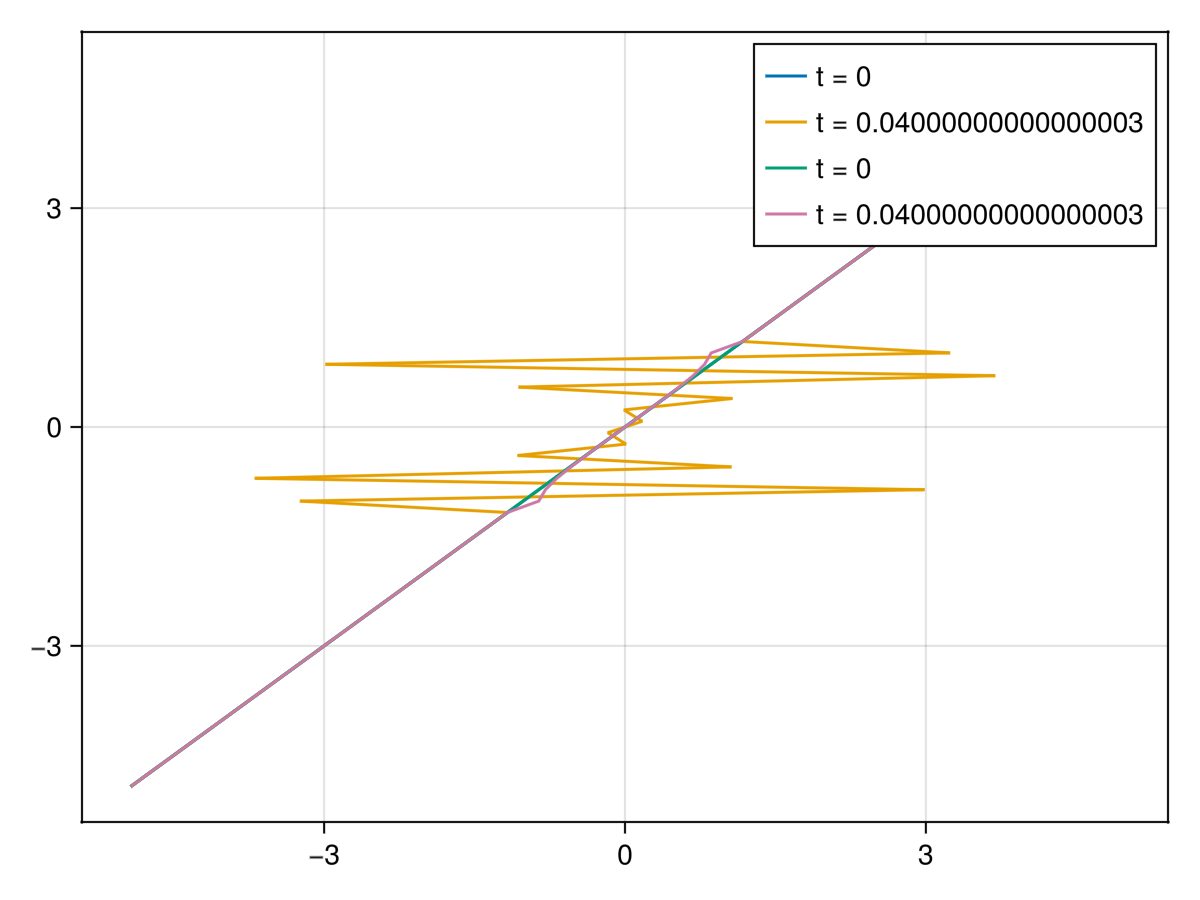

In [45]:
using Oceananigans
using Oceananigans.TurbulenceClosures: VerticallyImplicitTimeDiscretization

using GLMakie

# Make a grid
grid = RectilinearGrid(size=64, z=(-5, 5), topology=(Flat, Flat, Bounded))

# Build a model with one tracer and a constant, Laplacian (scalar) diffusivity
κ_neg(z, t) = ifelse(abs(z) < 1, -1, 0)
κ_pos(z, t) = ifelse(abs(z) < 1, +1, 0)

fig = Figure()
ax = Axis(fig[1, 1])

for κ = (κ_neg, κ_pos)
    vitd = VerticallyImplicitTimeDiscretization()
    closure = ScalarDiffusivity(vitd; κ)
    model = NonhydrostaticModel(; grid, closure, tracers=:c)

    # Set the initial condition
    #set!(model, c=z -> exp(-z^2 / 2))
    set!(model, c=z -> z)

    # Make a plot of the initial condition
    c = interior(model.tracers.c, 1, 1, :)
    z = znodes(model.tracers.c)
    lines!(ax, c, z, label="t = 0")

    # Build and run a simulation
    Δt = 0.1 * (10/grid.Nz)^2 
    simulation = Simulation(model; Δt=1e-3, stop_iteration=40)
    run!(simulation)

    # Plot the final state
    lines!(ax, c, z, label=string("t = ", time(simulation))) 
end

axislegend()
current_figure()

In [39]:
0.1 * (10/grid.Nz)^2

0.00244140625

# Okay, one more time, more slowly

That was fast! Let's walk through the script more slowly. The script takes the following steps:

1. Load `Oceananigans` and a plotting package called `GLMakie`.
2. Construct a simple one-dimensional grid spanning from $z=-5$ to $z=5$ with 64 grid points.
3. Build an object we call a "`closure`" representing diffusion by a scalar diffusivity coefficient, where the coefficient is set to `1`.
4. Build a model with the `grid` and `closure`, specifying that we want one tracer called `c`. (Here we use `NonhydrostaticModel`, but other models could be used since after all we are only diffusing a passive tracer. More on that later).
5. Set the initial condition to the desired functional form, a Gaussian.
6. Plot the initial condition (sometimes it's helpful to know what you're starting with).
7. Build and `run!` a `Simulation` until $t=1$ (using a time-step that we know will be numerically stable).
8. Plot the final condition.

Let's work through it. These two lines load the packages,

In [2]:
using Oceananigans
using GLMakie

Note that when we type `using PackageX`, this brings a bunch of names into our namespace that we can then use (like `RectilinearGrid`).
The names that are brought into the namespace by writing `using PackageX` are said to be "exported" by `PackageX`.
We can also write `import PackageX`, which doesn't bring any names into our name space.
For example, we could write

```
import Oceananigans
grid = Oceananigans.RectilinearGrid(size=64, z=(-5, 5), topology=(Flat, Flat, Bounded))
```

When we write `PackageX.name`, we're using a "qualified name".
These are two different ways of doing the same thing.
This will happen a lot --- there's often 100 ways to do something.
In these cases, we'll simply write our code according to our _style_.

The first thing to do in any Oceananigans problem is to define the domain and grid.
Here we want to do a 1D problem, so we use a RectilinearGrid with the x and y dimensions marked as "`Flat`".
For each dimension x, y, z, the topology can either be `Periodic`, `Bounded` or `Flat`.

In [3]:
grid = RectilinearGrid(size=64, z=(-5, 5), topology=(Flat, Flat, Bounded))

1×1×64 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── Flat x
├── Flat y
└── Bounded  z ∈ [-5.0, 5.0]      regularly spaced with Δz=0.15625

Next, we'll build an object called `ScalarDiffusivity`,

In [4]:
closure = ScalarDiffusivity(κ=1)

ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=1.0)

which represents diffusion by a constant scalar diffusivity with value `1`.
Oceananigans also supports arrays and functions as diffusivities.
To see some examples we can look at the docstring for `ScalarDiffusivity`,

In [5]:
?ScalarDiffusivity

search: ScalarDiffusivity VerticalScalarDiffusivity HorizontalScalarDiffusivity



```
ScalarDiffusivity(time_discretization = ExplicitTimeDiscretization(),
                  formulation = ThreeDimensionalFormulation(), FT = Float64;
                  ν = 0,
                  κ = 0,
                  discrete_form = false,
                  loc = (nothing, nothing, nothing),
                  parameters = nothing)
```

Return `ScalarDiffusivity` turbulence closure with viscosity `ν` and tracer diffusivities `κ` for each tracer field in `tracers`. If a single `κ` is provided, it is applied to all tracers. Otherwise `κ` must be a `NamedTuple` with values for every tracer individually.

# Arguments

  * `time_discretization`: either `ExplicitTimeDiscretization()` (default) or `VerticallyImplicitTimeDiscretization()`.
  * `formulation`:

      * `HorizontalFormulation()` for diffusivity applied in the horizontal direction(s)
      * `VerticalFormulation()` for diffusivity applied in the vertical direction,
      * `ThreeDimensionalFormulation()` (default) for diffusivity applied isotropically to all directions
  * `FT`: the float datatype (default: `Float64`)

# Keyword arguments

  * `ν`: Viscosity. `Number`, `AbstractArray`, `Field`, or `Function`.
  * `κ`: Diffusivity. `Number`, `AbstractArray`, `Field`, `Function`, or      `NamedTuple` of diffusivities with entries for each tracer.
  * `discrete_form`: `Boolean`; default: `false`.

When prescribing the viscosities or diffusivities as functions, depending on the value of keyword argument `discrete_form`, the constructor expects:

  * `discrete_form = false` (default): functions of the grid's native coordinates and time, e.g., `(x, y, z, t)` for a `RectilinearGrid` or `(λ, φ, z, t)` for a `LatitudeLongitudeGrid`.
  * `discrete_form = true`:

      * with `loc = (nothing, nothing, nothing)` (default): functions of `(i, j, k, grid, ℓx, ℓy, ℓz)` with `ℓx`, `ℓy`, and `ℓz` either `Face()` or `Center()`.
      * with `loc = (ℓx, ℓy, ℓz)` with `ℓx`, `ℓy`, and `ℓz` either `Face()` or `Center()`: functions of `(i, j, k, grid)`.
  * `parameters`: `NamedTuple` with parameters used by the functions that compute viscosity and/or diffusivity; default: `nothing`.

# Examples

```jldoctest ScalarDiffusivity
julia> using Oceananigans

julia> ScalarDiffusivity(ν=1000, κ=2000)
ScalarDiffusivity{ExplicitTimeDiscretization}(ν=1000.0, κ=2000.0)
```

```jldoctest ScalarDiffusivity
julia> const depth_scale = 100;

julia> @inline ν(x, y, z) = 1000 * exp(z / depth_scale)
ν (generic function with 1 method)

julia> ScalarDiffusivity(ν=ν)
ScalarDiffusivity{ExplicitTimeDiscretization}(ν=ν (generic function with 1 method), κ=0.0)
```

```jldoctest ScalarDiffusivity
julia> using Oceananigans.Grids: znode

julia> @inline function κ(i, j, k, grid, ℓx, ℓy, ℓz)
           z = znode(i, j, k, grid, ℓx, ℓy, ℓz)
           return 2000 * exp(z / depth_scale)
       end
κ (generic function with 1 method)

julia> ScalarDiffusivity(κ=κ, discrete_form=true)
ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=Oceananigans.TurbulenceClosures.DiscreteDiffusionFunction{Nothing, Nothing, Nothing, Nothing, typeof(κ)})
```

```jldoctest ScalarDiffusivity
julia> @inline function another_κ(i, j, k, grid, p)
           z = znode(i, j, k, grid)
           return 2000 * exp(z / p.depth_scale)
       end
another_κ (generic function with 1 method)

julia> ScalarDiffusivity(κ=another_κ, discrete_form=true, loc=(Center, Center, Face), parameters=(; depth_scale = 120.0))
ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=Oceananigans.TurbulenceClosures.DiscreteDiffusionFunction{Center, Center, Face, @NamedTuple{depth_scale::Float64}, typeof(another_κ)})
```


That's a particularly helpful docstring by the way.
If you find a docstring that isn't up to your standards, please improve it by submitting a PR!

Okay, we're ready to build a model, which is one of Oceananigans' core objects for coordinating a numerical experiment.

In [6]:
model = NonhydrostaticModel(; grid, closure, tracers=:c) # NonhydrostaticModel(grid=grid, closure=closure)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 1×1×64 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── advection scheme: Centered reconstruction order 2
├── tracers: c
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=0.0, κ=(c=1.0,))
├── buoyancy: Nothing
└── coriolis: Nothing

You can think of a "model" as representing the equations you would like to solve, along with a spatial discretization and a time-discretization of those equations.
The model also contains references to all of the prognostic and diagnostic fields that are involved in a simulation.
If you're interested in actually looking at the results of a simulation you've done, it's helpful to know a bit about the structure of the models.
For example, the tracer field `c` is located at `model.tracers.c`,

In [7]:
model.tracers.c

1×1×64 Field{Center, Center, Center} on RectilinearGrid on CPU
├── grid: 1×1×64 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Nothing, east: Nothing, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1×1×70 OffsetArray(::Array{Float64, 3}, 1:1, 1:1, -2:67) with eltype Float64 with indices 1:1×1:1×-2:67
    └── max=0.0, min=0.0, mean=0.0

There's more to know of course.
Note that we're using a "quasi Adams-Bashforth 2" timestepper.
This is a time-stepping method similar to Adams-Bashforth, but tweaked a bit to improve its numerical stability.
There's also an "advection scheme", which is "Centered reconstruction order 2" (aka "centered second-order" more colloquially).
More on that later.

Note that the last output shows the tracer is initialized with 0's.
Let's change that.
First we'll define a function that represents the distribution we'd like to set the tracer to (Julia is nice, it let's us define functions on one line),

In [8]:
cᵢ(z) = exp(-z^2 / 2)

cᵢ (generic function with 1 method)

and then we'll use the function `set!` to change `model.tracers.c`,

In [9]:
set!(model, c=cᵢ)
model.tracers.c

1×1×64 Field{Center, Center, Center} on RectilinearGrid on CPU
├── grid: 1×1×64 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── boundary conditions: FieldBoundaryConditions
│   └── west: Nothing, east: Nothing, south: Nothing, north: Nothing, bottom: ZeroFlux, top: ZeroFlux, immersed: ZeroFlux
└── data: 1×1×70 OffsetArray(::Array{Float64, 3}, 1:1, 1:1, -2:67) with eltype Float64 with indices 1:1×1:1×-2:67
    └── max=0.996953, min=5.49085e-6, mean=0.250663

`c` has a maximum pretty close to 1, but not equal to it because, well, we're living in a discrete world.

We're pretty close.
Next we build a `Simulation`, which is basically a simple helper utility for coordinating the time-integration of a model.
The `Simulation` knows the time-step we're trying to take, as well as things like stopping criterion.
Note that the stopping criterion can actually be anything.
For convenience, Oceananigans provides a streamlined interface for setting the stop criterion to `stop_time`, `stop_iteration`, or a `wall_time_limit` (for when you have a finite electricity budget).

The time-step size we pick could use a bit of explaining.
The numerical simulation will complete faster if we pick as long a time-step as possible.
On the other hand, if the time step is too long, the time integration will be "unstable", usually causing the simulation to output NaN.
But we want Oceananigans to be more than a NaN factory.
In order to pick the right time step size, we have to know a bit about our problem.
In this example we're considering the diffusion of a Gaussian, and we're using explicit time-stepping. That means that the time-step has to be a bit smaller than the time it takes information to diffuse across a grid cell.
If the grid spacing is $\Delta z$, and the diffusivity is $\kappa$, then that time-scale is

$$ \tau \sim \Delta z^2 / \kappa $$

Ok, we made our lives a bit easier by choosing $\kappa = 1$. And $\Delta z = 10 / N_z$, where $10$ is the width of the domain and $N_z$ is the number of grid points.
So if we want a "safety factor" of 10 (note, we could compute exactly the stable time-step for Adams-Bashforth 2, if we wanted to) we'll set out time-step to be 1/10th of the time-scale $\tau$, or in other words,

$$ \Delta t = \frac{1}{10} \left ( \frac{10}{N_z} \right )^2 $$

Okay, now we're ready to build the simulation,

In [10]:
simulation = Simulation(model, Δt=0.1*(10/grid.Nz)^2, stop_time=1)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 2.441 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 1 second
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [11]:
run!(simulation)

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (566.583 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (828.792 μs).
[ Info: Simulation is stopping after running for 200.227 ms.
[ Info: Simulation time 1 second equals or exceeds stop time 1 second.


In [12]:
set!(model, c=cᵢ)
c = model.tracers.c
model.clock.time = 0
model.clock.iteration = 0

progress(sim) = @info string("Iter: ", iteration(sim), ", time: ", time(sim), ", max(c):", maximum(c))
simulation.callbacks[:progress] = Callback(progress, IterationInterval(100))

run!(simulation)

[ Info: Initializing simulation...
[ Info: Iter: 0, time: 0.0, max(c):0.9969528940670334
[ Info:     ... simulation initialization complete (13.551 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.332 ms).
[ Info: Iter: 100, time: 0.244140625, max(c):0.8186360677659976
[ Info: Iter: 200, time: 0.48828125, max(c):0.7107937068451599
[ Info: Iter: 300, time: 0.732421875, max(c):0.6366850340462434
[ Info: Iter: 400, time: 0.9765625, max(c):0.5817579295626495
[ Info: Simulation is stopping after running for 208.668 ms.
[ Info: Simulation time 1 second equals or exceeds stop time 1 second.


In [13]:
output_writer = JLD2OutputWriter(model, model.tracers,
                                 filename = "gaussian_diffusion.jld2",
                                 schedule = TimeInterval(0.1),
                                 overwrite_existing = true)

simulation.output_writers[:jld2] = output_writer

JLD2OutputWriter scheduled on TimeInterval(100 ms):
├── filepath: ./gaussian_diffusion.jld2
├── 1 outputs: c
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
├── file_splitting: NoFileSplitting
└── file size: 19.9 KiB

In [14]:
set!(model, c=cᵢ)
c = model.tracers.c
model.clock.time = 0
model.clock.iteration = 0
run!(simulation)

[ Info: Initializing simulation...
[ Info: Iter: 0, time: 0.0, max(c):0.9969528940670334
[ Info:     ... simulation initialization complete (717.093 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (7.752 ms).
[ Info: Iter: 100, time: 0.2439453125, max(c):0.8187276877056542
[ Info: Iter: 200, time: 0.487890625, max(c):0.7109187233226338
[ Info: Iter: 300, time: 0.73173828125, max(c):0.6368461296543032
[ Info: Iter: 400, time: 0.9756835937499999, max(c):0.5819184621629658
[ Info: Simulation is stopping after running for 947.695 ms.
[ Info: Simulation time 1 second equals or exceeds stop time 1 second.


In [15]:
ct = FieldTimeSeries("gaussian_diffusion.jld2", "c")

1×1×64×11 FieldTimeSeries{InMemory} located at (Center, Center, Center) of c at gaussian_diffusion.jld2
├── grid: 1×1×64 RectilinearGrid{Float64, Flat, Flat, Bounded} on CPU with 0×0×3 halo
├── indices: (1:1, 1:1, 1:64)
├── time_indexing: Linear()
├── backend: InMemory()
├── path: gaussian_diffusion.jld2
├── name: c
└── data: 1×1×64×11 OffsetArray(::Array{Float64, 4}, 1:1, 1:1, 1:64, 1:11) with eltype Float64 with indices 1:1×1:1×1:64×1:11
    └── max=0.996953, min=5.49085e-6, mean=0.250663

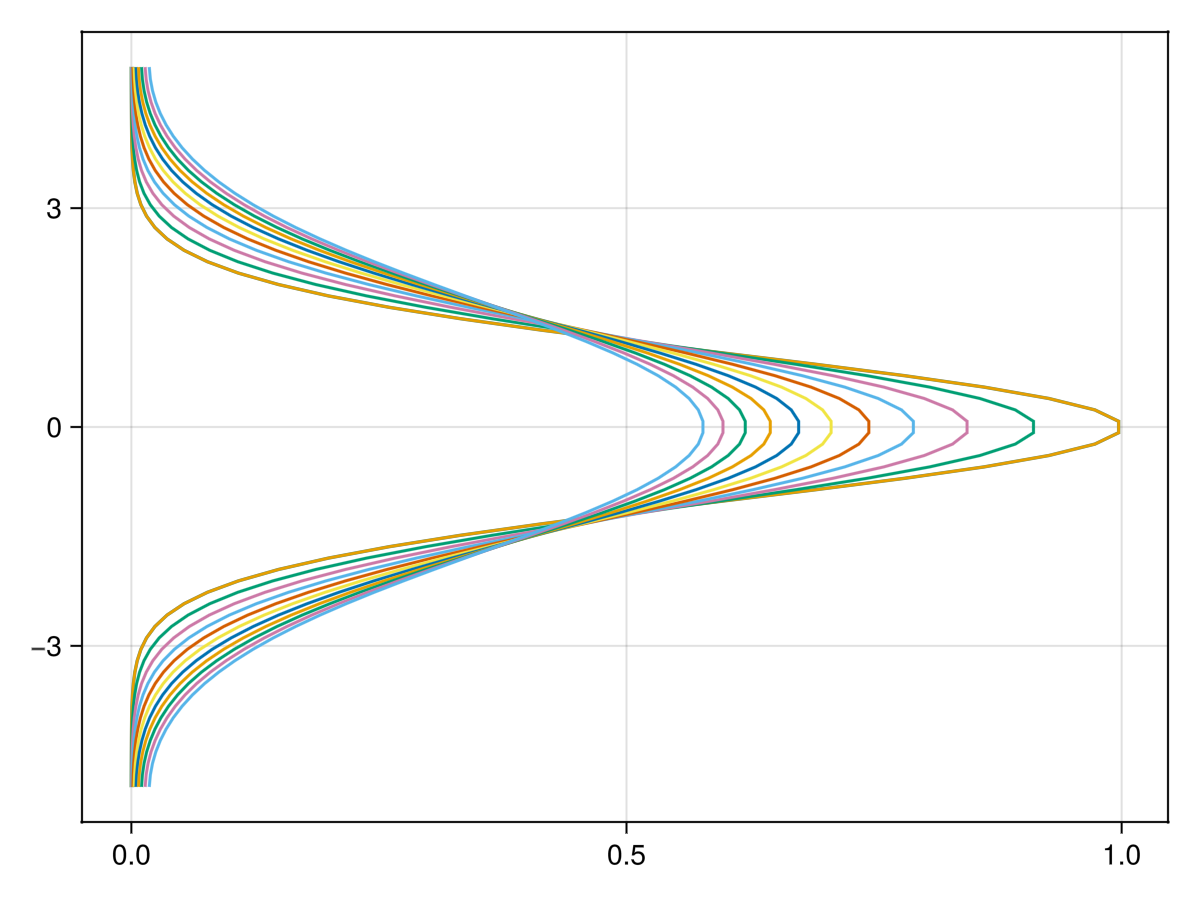

In [16]:
c1 = interior(ct[1], 1, 1, :)
z = znodes(ct)
lines(c1, z)

Nt = length(ct)
for n = 1:Nt
    cn = interior(ct[n], 1, 1, :)
    lines!(cn, z)
end
   
current_figure()

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (58.276 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (632.800 ms).
[ Info: Simulation is stopping after running for 702.305 ms.
[ Info: Model iteration 10 equals or exceeds stop iteration 10.


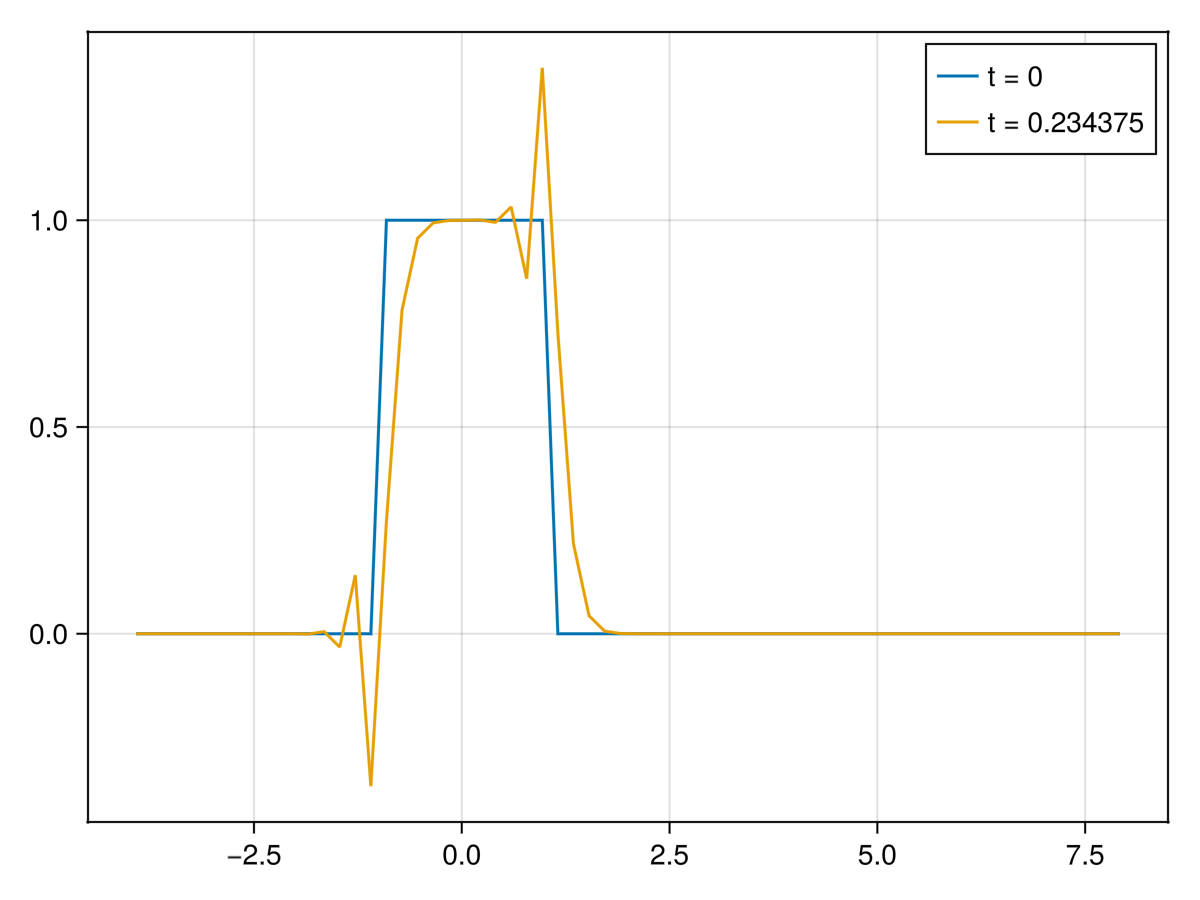

In [17]:
# Make a grid
grid = RectilinearGrid(size=64, x=(-4, 8), topology=(Periodic, Flat, Flat))

# Build a model with one tracer and a constant, Laplacian (scalar) diffusivity
u = XFaceField(grid)
set!(u, 1)
tracer_advection = CenteredSecondOrder()
velocities = PrescribedVelocityFields(u=u)
model = HydrostaticFreeSurfaceModel(; grid, tracer_advection, velocities, buoyancy=nothing, tracers=:c)

# Set the initial condition
set!(model, c= x -> abs(x) > 1 ? 0 : 1)

# Make a plot of the initial condition
c = interior(model.tracers.c, :, 1, 1)
x = xnodes(model.tracers.c)
lines(x, c, label="t = 0")

# Build and run a simulation
Δt = 0.1 * 15/grid.Nx 
simulation = Simulation(model; Δt, stop_iteration=10)
run!(simulation)

# Plot the final state
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (58.809 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (337.329 ms).
[ Info: Simulation is stopping after running for 405.168 ms.
[ Info: Model iteration 10 equals or exceeds stop iteration 10.


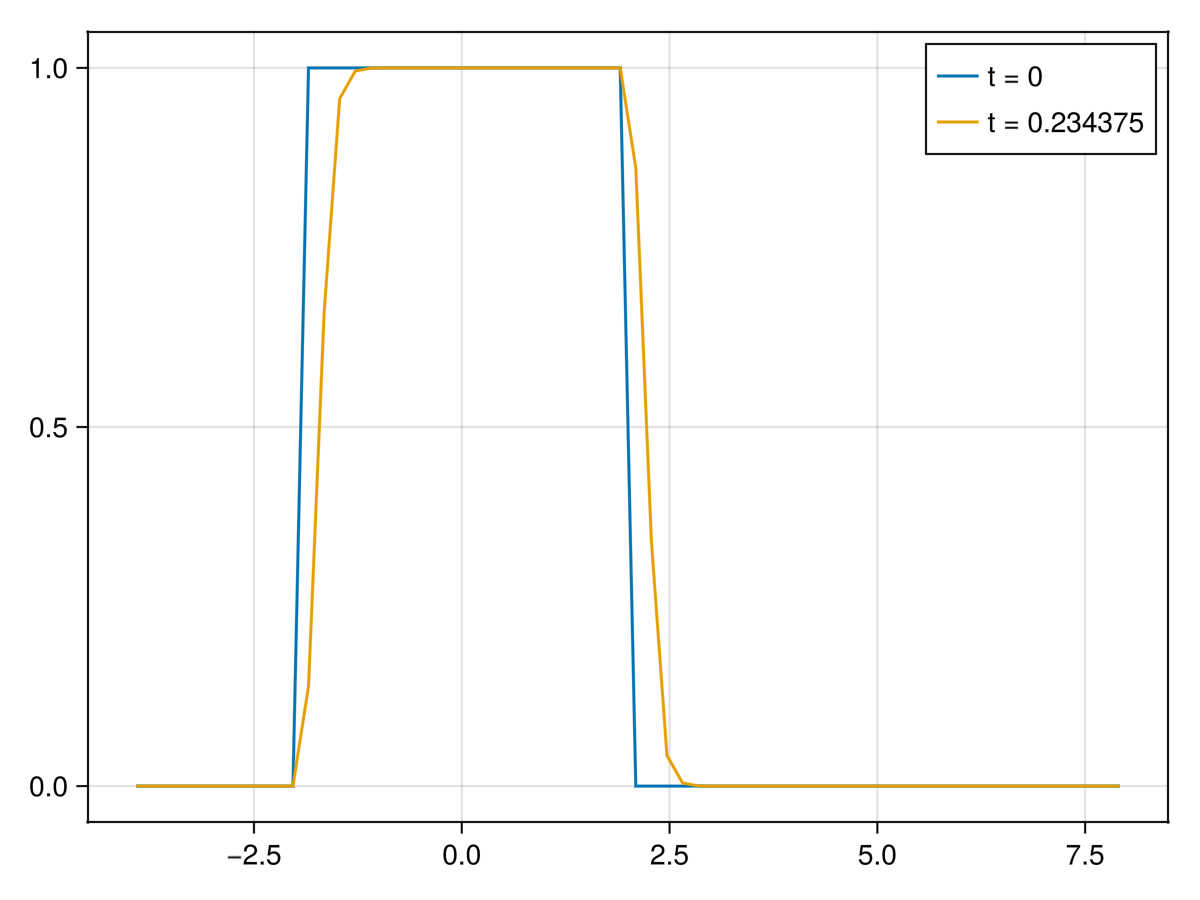

In [18]:
tracer_advection = WENO()
model = HydrostaticFreeSurfaceModel(; grid, tracer_advection, velocities, buoyancy=nothing, tracers=:c)

# Set the initial condition
set!(model, c= x -> abs(x) > 2 ? 0 : 1)

# Make a plot of the initial condition
c = interior(model.tracers.c, :, 1, 1)
x = xnodes(model.tracers.c)
lines(x, c, label="t = 0")

# Build and run a simulation
Δt = 0.1 * 15/grid.Nx 
simulation = Simulation(model; Δt, stop_iteration=10)
run!(simulation)

# Plot the final state
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (396.792 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (193.917 μs).
[ Info: Simulation is stopping after running for 15.315 ms.
[ Info: Model iteration 110 equals or exceeds stop iteration 110.


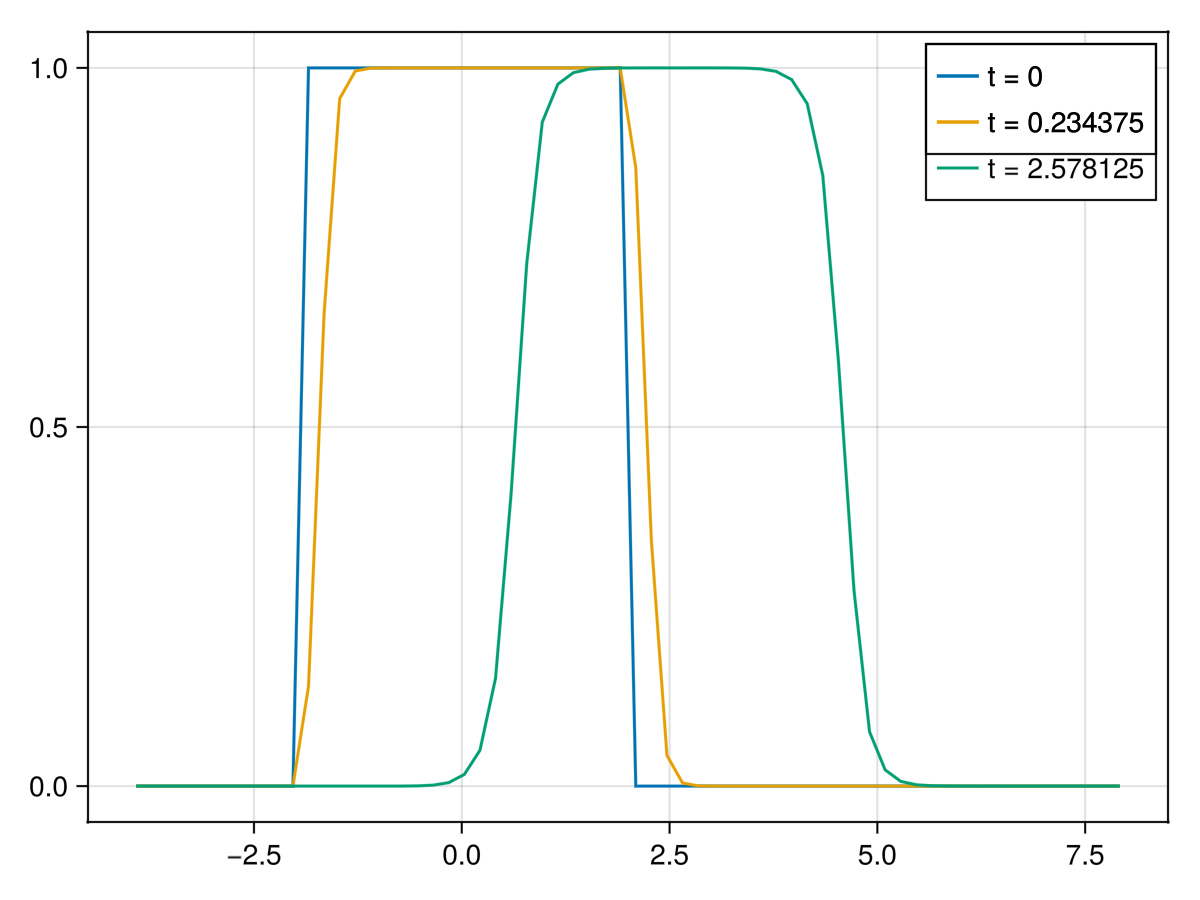

In [19]:
simulation.stop_iteration += 100
run!(simulation)
lines!(x, c, label=string("t = ", time(simulation)))
axislegend()
current_figure()

[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (60.278 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (631.270 ms).
[ Info: Simulation is stopping after running for 755.531 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (267.541 μs)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (337.667 μs).
[ Info: Simulation is stopping after running for 78.946 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (57.960 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (334.327 ms).
[ Info: Simulation is stopping after running for 484.683 ms.
[ Info: Simulation time 4 seconds equals or exceeds stop time 4 seconds.
[ Info: Initiali

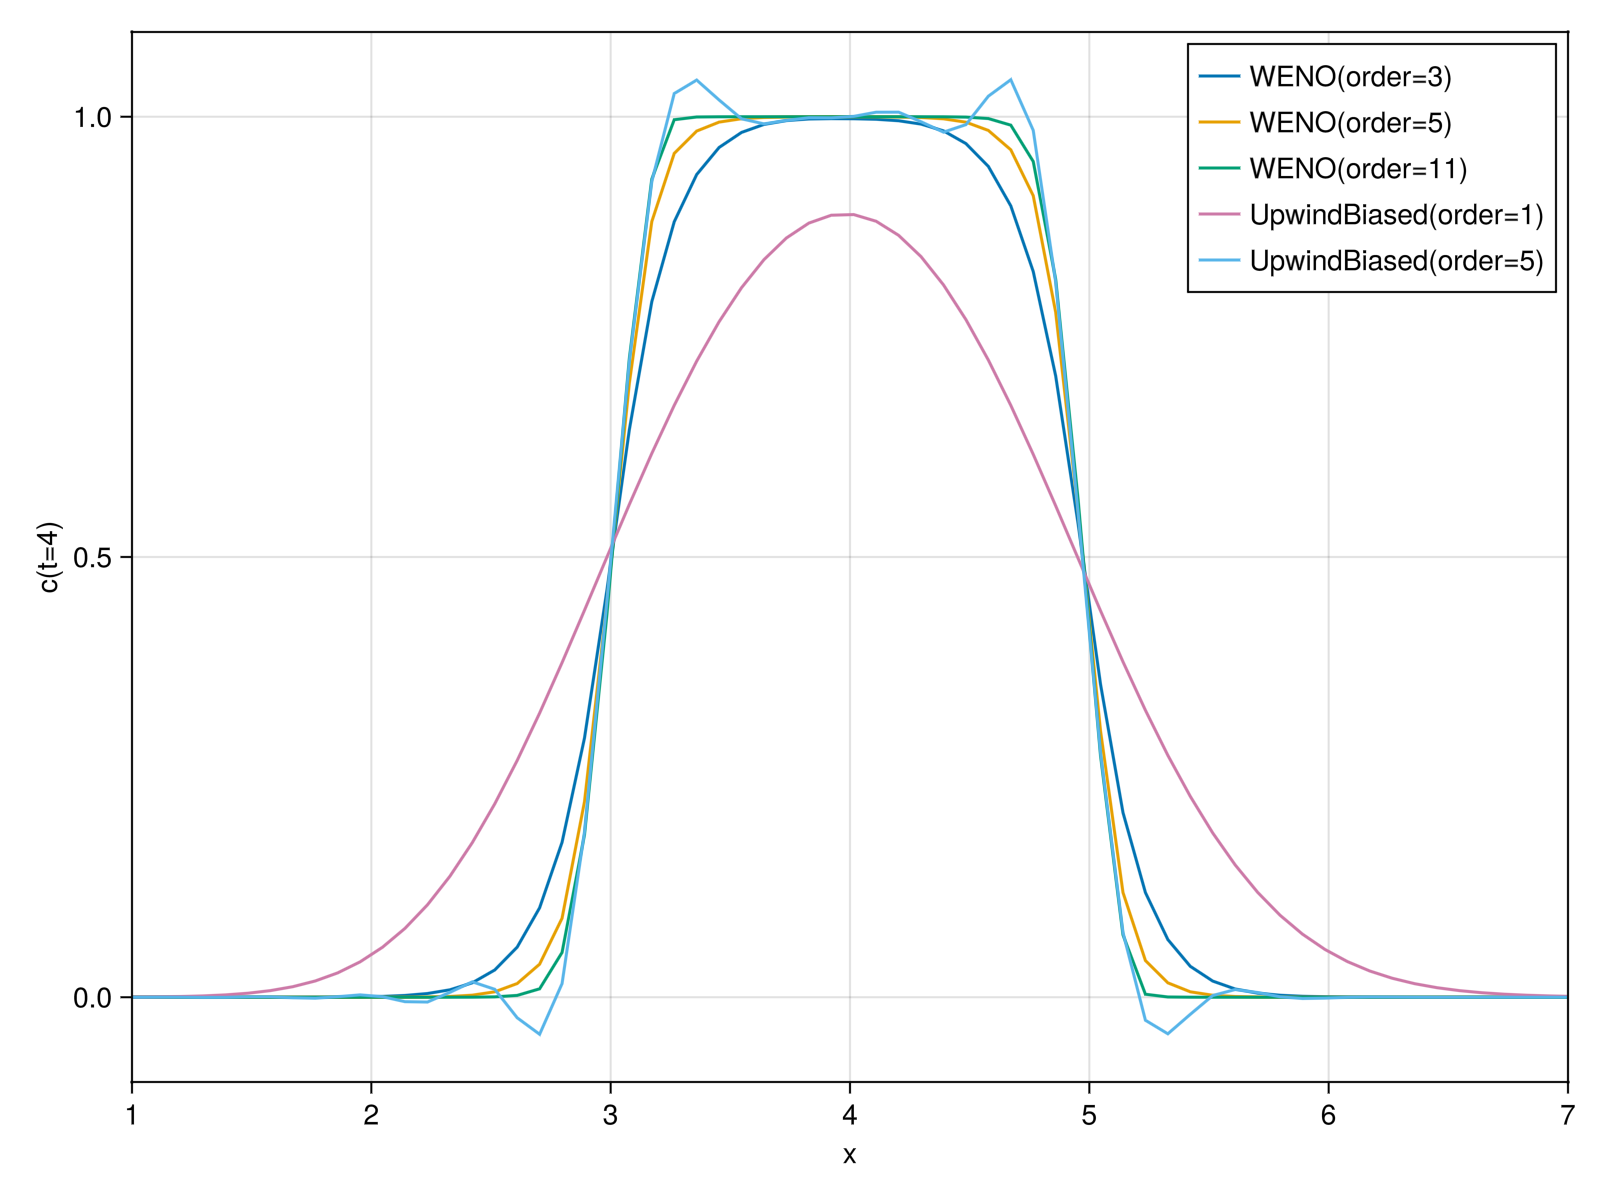

In [20]:
"""
    advect_tracer(advection_scheme, Nx=128, stop_time=4)

Advect a tracer with a top-hat profile until `stop_time` using `Nx` grid points.
Returns `x, c`.
"""
function advect_tracer(advection_scheme, Nx=128, stop_time=4)
    # Make a grid
    grid = RectilinearGrid(size=Nx, x=(-4, 8), halo=7, topology=(Periodic, Flat, Flat))

    # Build a model with one tracer and a constant, Laplacian (scalar) diffusivity
    u = XFaceField(grid)
    set!(u, 1)
    velocities = PrescribedVelocityFields(u=u)
    model = HydrostaticFreeSurfaceModel(; grid, tracer_advection=advection_scheme, velocities, buoyancy=nothing, tracers=:c)

    # Set the initial condition
    set!(model, c= x -> abs(x) > 1 ? 0 : 1)
    
    # Build and run a simulation
    Δt = 0.1 * 12/Nx 
    simulation = Simulation(model; Δt, stop_time)
    run!(simulation)
    
    c = interior(model.tracers.c, :, 1, 1)
    x = xnodes(model.tracers.c)
    
    return x, c
end

fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], xlabel="x", ylabel="c(t=4)")

for N = (3, 5, 11)
    scheme = WENO(order=N)
    x, c = advect_tracer(scheme)
    lines!(ax, x, c, label="WENO(order=$N)")
end

for N = (1, 5)
    x, c = advect_tracer(UpwindBiased(order=N))
    lines!(ax, x, c, label="UpwindBiased(order=$N)")
end

axislegend(ax)
xlims!(ax, 1, 7)
fig